## 1. Interploate the missing dates.

The following dates are missing in the dataset:



In [ ]:
import pandas as pd

# Load the CSV file
basin_id = "05535070"
file_path = f'c:/Users/ybrot/Desktop/course/UROP/GAGEii_modeling/US_climate_discharge_data/{basin_id}.csv'
df = pd.read_csv(file_path)
df.rename(columns={"Date": "date"}, inplace=True)

# Ensure the 'date' column is in datetime format
df['date'] = pd.to_datetime(df['date'])

# Set the 'date' column as the index
df.set_index('date', inplace=True)

# Generate a date range from the minimum to the maximum date in the dataframe
date_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')

# Reindex the dataframe to this date range
df_reindexed = df.reindex(date_range)

# Find missing dates
missing_dates = df_reindexed[df_reindexed.isnull().any(axis=1)].index

# Print missing dates
print("Missing dates:")
for date in missing_dates:
    print(date.strftime('%Y-%m-%d'))

# Check frequency
frequency = pd.infer_freq(df.index)
print(f"Detected frequency: {frequency}")

Missing dates:
1980-12-31
1984-12-31
1988-12-31
1992-12-31
1996-12-31
2000-12-31
2004-12-31
2008-12-31
2012-12-31
2016-12-31
2020-12-31
Detected frequency: None


Therefore, we will interpolate the missing dates in the dataset.

In [ ]:
import os
import pandas as pd
from tqdm import tqdm

# Define the input and output folders
input_folder = 'climate_discharge_data'
output_folder = 'data/csv_files'
basins_list_file = 'basin_list/basin_list_complete.txt'

# Read the list of basin IDs
with open(basins_list_file, 'r') as file:
    basin_ids = file.read().splitlines()

# Ensure the output folder exists
os.makedirs(output_folder, exist_ok=True)

# Function to interpolate missing dates
def interpolate_missing_dates(df, missing_dates):
    # Ensure the 'date' column is in datetime format
    df.rename(columns={"Date": "date"}, inplace=True)
    df['date'] = pd.to_datetime(df['date'])
    # Set the 'date' column as the index
    df.set_index('date', inplace=True)
    # Generate a complete date range from the minimum to the maximum date in the dataframe
    date_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')
    # Reindex the dataframe to this date range
    df_reindexed = df.reindex(date_range)
    # Interpolate missing values
    df_interpolated = df_reindexed.interpolate(method='time')
    return df_interpolated

# Process each CSV file
for basin_id in tqdm(basin_ids):
    input_file = os.path.join(input_folder, f'{basin_id}.csv')
    output_file = os.path.join(output_folder, f'{basin_id}.csv')
    
    # Read the CSV file
    df = pd.read_csv(input_file)
    
    # Interpolate missing dates
    missing_dates = [
        '1980-12-31', '1984-12-31', '1988-12-31', '1992-12-31', 
        '1996-12-31', '2000-12-31', '2004-12-31', '2008-12-31', 
        '2012-12-31', '2016-12-31', '2020-12-31'
    ]
    df_interpolated = interpolate_missing_dates(df, missing_dates)
    
    # Reset the index to have 'date' as a column again
    df_interpolated.reset_index(inplace=True)
    df_interpolated.rename(columns={'index': 'date'}, inplace=True)
    
    # Convert all negative values in the "discharge" column to NaN
    df_interpolated['discharge'] = df_interpolated['discharge'].apply(lambda x: x if x >= 0 else pd.NA)
    
    # If the basin_id does not start with "02", divide the values in the "discharge" column by 35.315
    # Basins not starting with "02" are US stations, using an undesired unit - cubic ft / s
    if not basin_id.startswith("02"):
        df_interpolated['discharge'] = df_interpolated['discharge'] / 35.315
    
    # Write the output CSV file
    df_interpolated.to_csv(output_file, index=False)

print("Interpolation and file writing completed.")

100%|██████████| 976/976 [03:33<00:00,  4.58it/s]

Interpolation and file writing completed.


## 2. Check the data for missing dates.

In [ ]:
import os
import pandas as pd

# Define the directory containing the imputed CSV files
directory = 'data/csv_files'

# Initialize a flag to check if all files meet the condition
all_files_valid = True
non_satisfying_files = []

# Get the list of all file names in the directory
basin_ids = [f.split('.')[0] for f in os.listdir(directory) if f.endswith('.csv')]

# Iterate over each file in the directory
for basin_id in tqdm(basin_ids):
    
    file_path = f'data/csv_files/{basin_id}.csv'
    file_name = f'{basin_id}.csv'
        
    # Read the CSV file into a DataFrame
    df = pd.read_csv(file_path)
    df.rename(columns={"Date": "date"}, inplace=True)
    # Ensure the 'date' column is in datetime format and set as index
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df.set_index('date', inplace=True)
    
    # Create a full date range and check for missing dates
    full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')
    missing_dates = full_range.difference(df.index)
    
    # Check if the frequency of missing dates is 'D'
    if missing_dates.freq != 'D':
        # print(f"File {file_name} does not meet the condition.")
        # print(f"Frequency of missing dates: {missing_dates.freq}")
        all_files_valid = False
        non_satisfying_files.append(file_name)
        

if all_files_valid:
    print("All files meet the condition.")
else:
    print("Some files do not meet the condition.")

100%|██████████| 976/976 [00:16<00:00, 60.14it/s]

All files meet the condition.


## 3. Convert the data to a time series. (NetCDF)

In [ ]:
from file_conversion import DataFrame_to_CDF
from tqdm import tqdm
import pandas as pd
import os

def convert_csv_to_cdf(input_folder: str, output_folder: str):
    # Ensure the output folder exists
    os.makedirs(output_folder, exist_ok=True)
    
    # Get all CSV files in the input folder
    csv_files = [f for f in os.listdir(input_folder) if f.endswith('.csv')]
    
    for csv_file in tqdm(csv_files):
        # Construct the file path for the CSV file
        csv_file_path = os.path.join(input_folder, csv_file)
        
        # Read the CSV file into a DataFrame
        df = pd.read_csv(csv_file_path, index_col='date')
        df.index = pd.to_datetime(df.index)
        
        # Convert the DataFrame to a CDF file
        basin_id = os.path.splitext(csv_file)[0]
        DataFrame_to_CDF(df, output_folder, basin_id)


In [ ]:
input_folder = './data/csv_files'
output_folder = './data/time_series'
convert_csv_to_cdf(input_folder, output_folder)

100%|██████████| 976/976 [01:31<00:00, 10.65it/s]


## 4. Data Normalization

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Define the directory containing the CSV files
data_folder = 'data/csv_files'

# Initialize an empty list to store the data
data_list = []

# Iterate over all CSV files in the directory
for file_name in tqdm(os.listdir(data_folder)):
    if file_name.endswith('.csv'):
        file_path = os.path.join(data_folder, file_name)
        df = pd.read_csv(file_path, index_col='date')
        data_list.append(df)

# Concatenate all data into a single DataFrame
combined_df = pd.concat(data_list)



100%|██████████| 976/976 [00:22<00:00, 43.25it/s]


In [4]:
combined_df.info

<bound method DataFrame.info of             discharge       dayl       prcp       srad        swe      tmax  \
date                                                                          
1980-01-01   2.320000  29643.209   0.000000  134.00153  82.957115 -6.852998   
1980-01-02   2.320000  29701.252   0.000000  161.91626  82.957115 -9.147027   
1980-01-03   2.320000  29764.002   0.000000  181.16530  82.957115 -8.942873   
1980-01-04   2.350000  29831.414   3.934299  109.06445  86.891470 -7.289824   
1980-01-05   2.350000  29903.428  10.268102   75.10631  97.159590 -6.403406   
...               ...        ...        ...        ...        ...       ...   
2023-12-27   0.818349  32141.787   0.000000  182.31155   0.000000  5.225181   
2023-12-28   0.654113  32168.037   7.673132   86.21674   0.000000  5.366386   
2023-12-29   1.446977  32198.127   0.034699  136.42868   0.000000  4.473735   
2023-12-30   0.959932  32232.021   0.000000  176.49336   0.000000  3.466988   
2023-12-31   0.65128

8it [10:12, 76.56s/it]


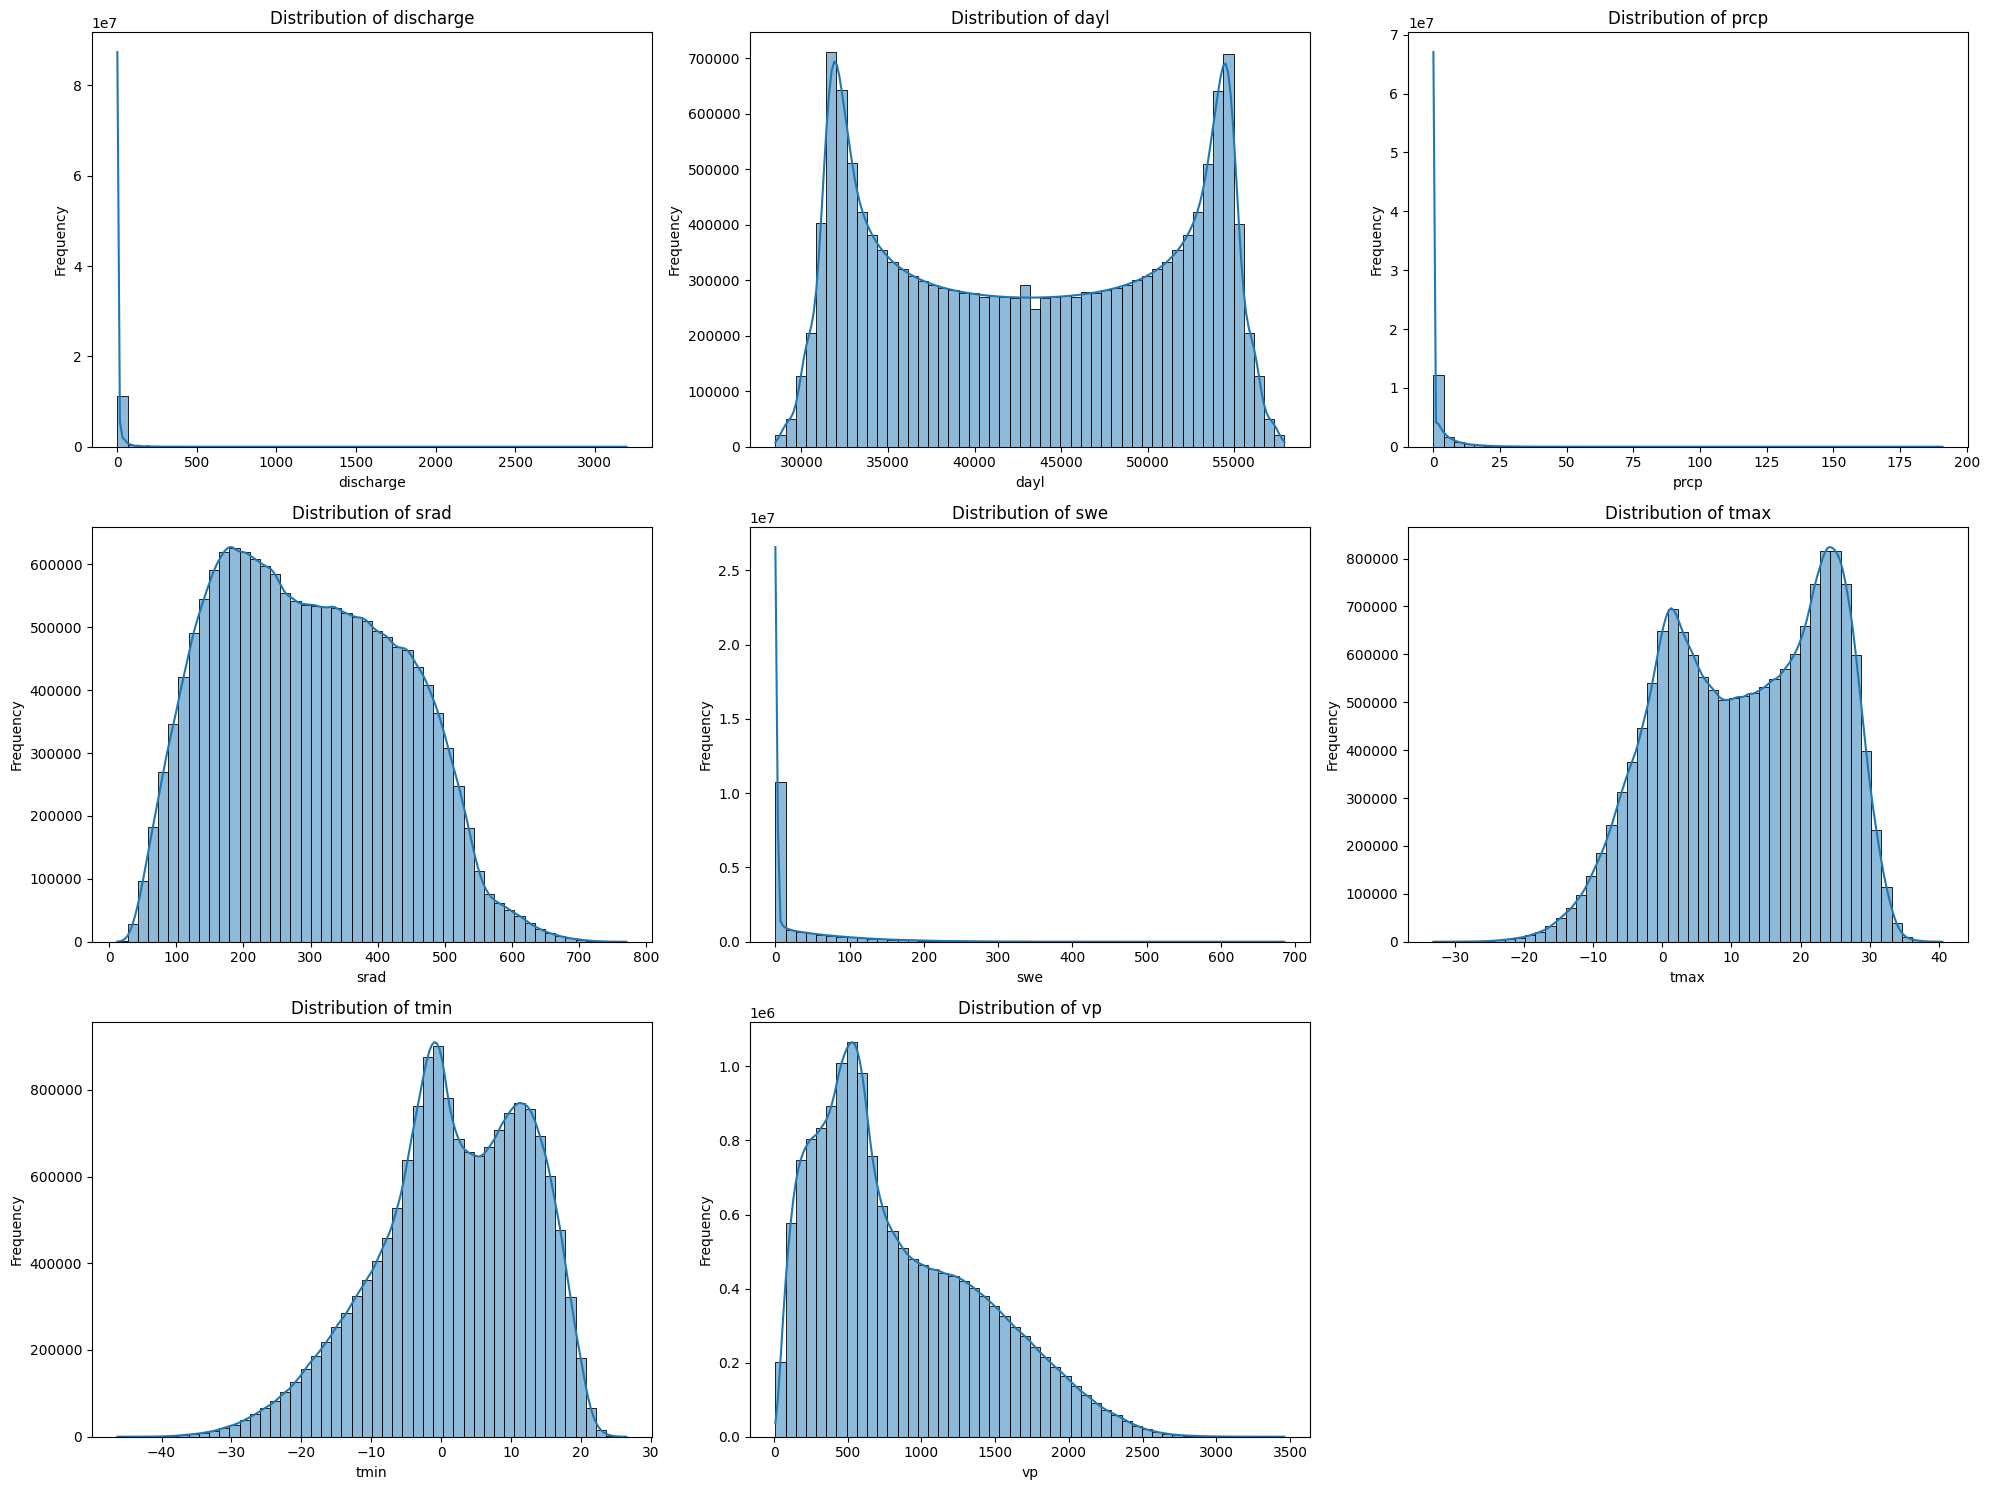

In [4]:
# Plot the distribution of each variable
variables = ['discharge', 'dayl', 'prcp', 'srad', 'swe', 'tmax', 'tmin', 'vp']

plt.figure(figsize=(20, 15))
for i, variable in tqdm(enumerate(variables, 1)):
    plt.subplot(3, 3, i)
    sns.histplot(combined_df[variable].dropna(), bins=50, kde=True)
    plt.xlabel(variable)
    plt.ylabel('Frequency')
    plt.title(f'Distribution of {variable}')

plt.tight_layout()
plt.show()

### Log Transformation

In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np

# Define the directory containing the CSV files
data_folder = 'data/csv_files'

# Initialize an empty list to store the data
data_list = []

# Iterate over all CSV files in the directory
for file_name in tqdm(os.listdir(data_folder)):
    if file_name.endswith('.csv'):
        file_path = os.path.join(data_folder, file_name)
        df = pd.read_csv(file_path, index_col='date')
        
        # Add a very small value to "discharge", "prcp", and "swe" variables
        df['discharge'] += 1e-6
        df['prcp'] += 1e-6
        df['swe'] += 1e-6
        
        # Apply log transformation
        df['discharge'] = df['discharge'].apply(lambda x: np.log(x))
        df['prcp'] = df['prcp'].apply(lambda x: np.log(x))
        df['swe'] = df['swe'].apply(lambda x: np.log(x))
        
        data_list.append(df)

# Concatenate all data into a single DataFrame
combined_df = pd.concat(data_list)

# Collect min and max values for each variable
min_max_values = {}
variables = ['discharge', 'dayl', 'prcp', 'srad', 'swe', 'tmax', 'tmin', 'vp']

for variable in variables:
    min_max_values[variable] = {
        'min': combined_df[variable].min(),
        'max': combined_df[variable].max()
    }

# Export the min and max values to a text file
with open('min_max_values.txt', 'w') as file:
    for variable, values in min_max_values.items():
        file.write(f"{variable}:\n")
        file.write(f"  min: {values['min']}\n")
        file.write(f"  max: {values['max']}\n")

100%|██████████| 976/976 [01:05<00:00, 14.92it/s]


3it [07:03, 141.25s/it]


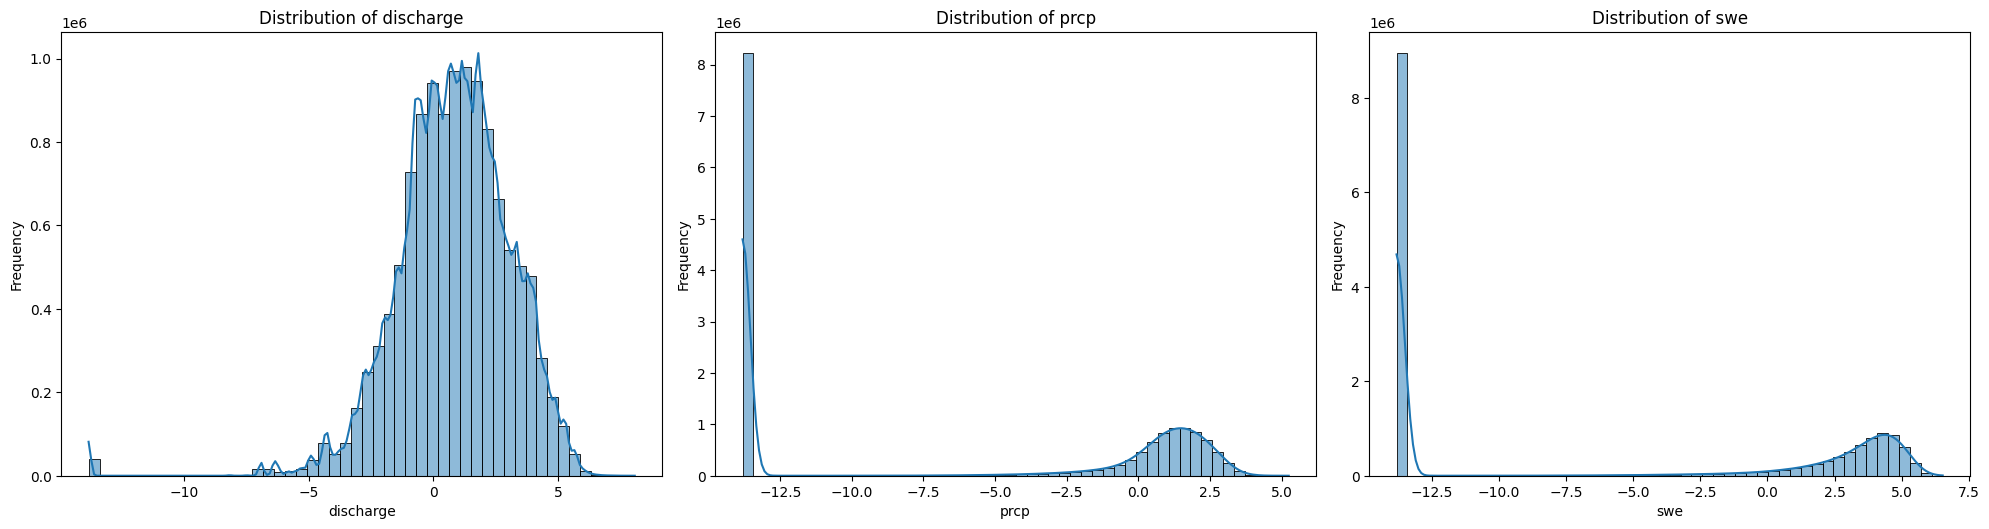

In [4]:
variables = ['discharge', 'prcp',  'swe']

plt.figure(figsize=(20, 15))
for i, variable in tqdm(enumerate(variables, 1)):
    plt.subplot(3, 3, i)
    sns.histplot(combined_df[variable].dropna(), bins=50, kde=True)
    plt.xlabel(variable)
    plt.ylabel('Frequency')
    plt.title(f'Distribution of {variable}')

plt.tight_layout()
plt.show()

## Apply Transformation

In [1]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm

# Define the directories
data_folder = 'data/csv_files'
output_folder = 'data/processed_csv_files'

# Ensure the output directory exists
os.makedirs(output_folder, exist_ok=True)

# Read the min and max values from the text file
min_max_values = {}
with open('min_max_values.txt', 'r') as file:
    lines = file.readlines()
    for i in range(0, len(lines), 3):
        variable = lines[i].strip().replace(':', '')
        min_value = float(lines[i+1].split(': ')[1])
        max_value = float(lines[i+2].split(': ')[1])
        min_max_values[variable] = {'min': min_value, 'max': max_value}

# Iterate over all CSV files in the directory
for file_name in tqdm(os.listdir(data_folder)):
    if file_name.endswith('.csv'):
        file_path = os.path.join(data_folder, file_name)
        df = pd.read_csv(file_path, index_col='date')
        
        # Add a very small value to "discharge", "prcp", and "swe" variables
        df['discharge'] += 1e-6
        df['prcp'] += 1e-6
        df['swe'] += 1e-6
        
        # Apply log transformation
        df['discharge'] = df['discharge'].apply(lambda x: np.log(x))
        df['prcp'] = df['prcp'].apply(lambda x: np.log(x))
        df['swe'] = df['swe'].apply(lambda x: np.log(x))
        
        # Apply min-max standardization
        for variable in df.columns:
            min_value = min_max_values[variable]['min']
            max_value = min_max_values[variable]['max']
            df[variable] = (df[variable] - min_value) / (max_value - min_value)
        
        # Save the processed file to the output folder
        output_file_path = os.path.join(output_folder, file_name)
        df.to_csv(output_file_path)

100%|██████████| 976/976 [02:54<00:00,  5.59it/s]


In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Define the directory containing the CSV files
data_folder = 'data/processed_csv_files'

# Initialize an empty list to store the data
data_list = []

# Iterate over all CSV files in the directory
for file_name in tqdm(os.listdir(data_folder)):
    if file_name.endswith('.csv'):
        file_path = os.path.join(data_folder, file_name)
        df = pd.read_csv(file_path, index_col='date')
        data_list.append(df)

# Concatenate all data into a single DataFrame
combined_df = pd.concat(data_list)



100%|██████████| 976/976 [00:40<00:00, 24.38it/s]


8it [10:58, 82.31s/it]


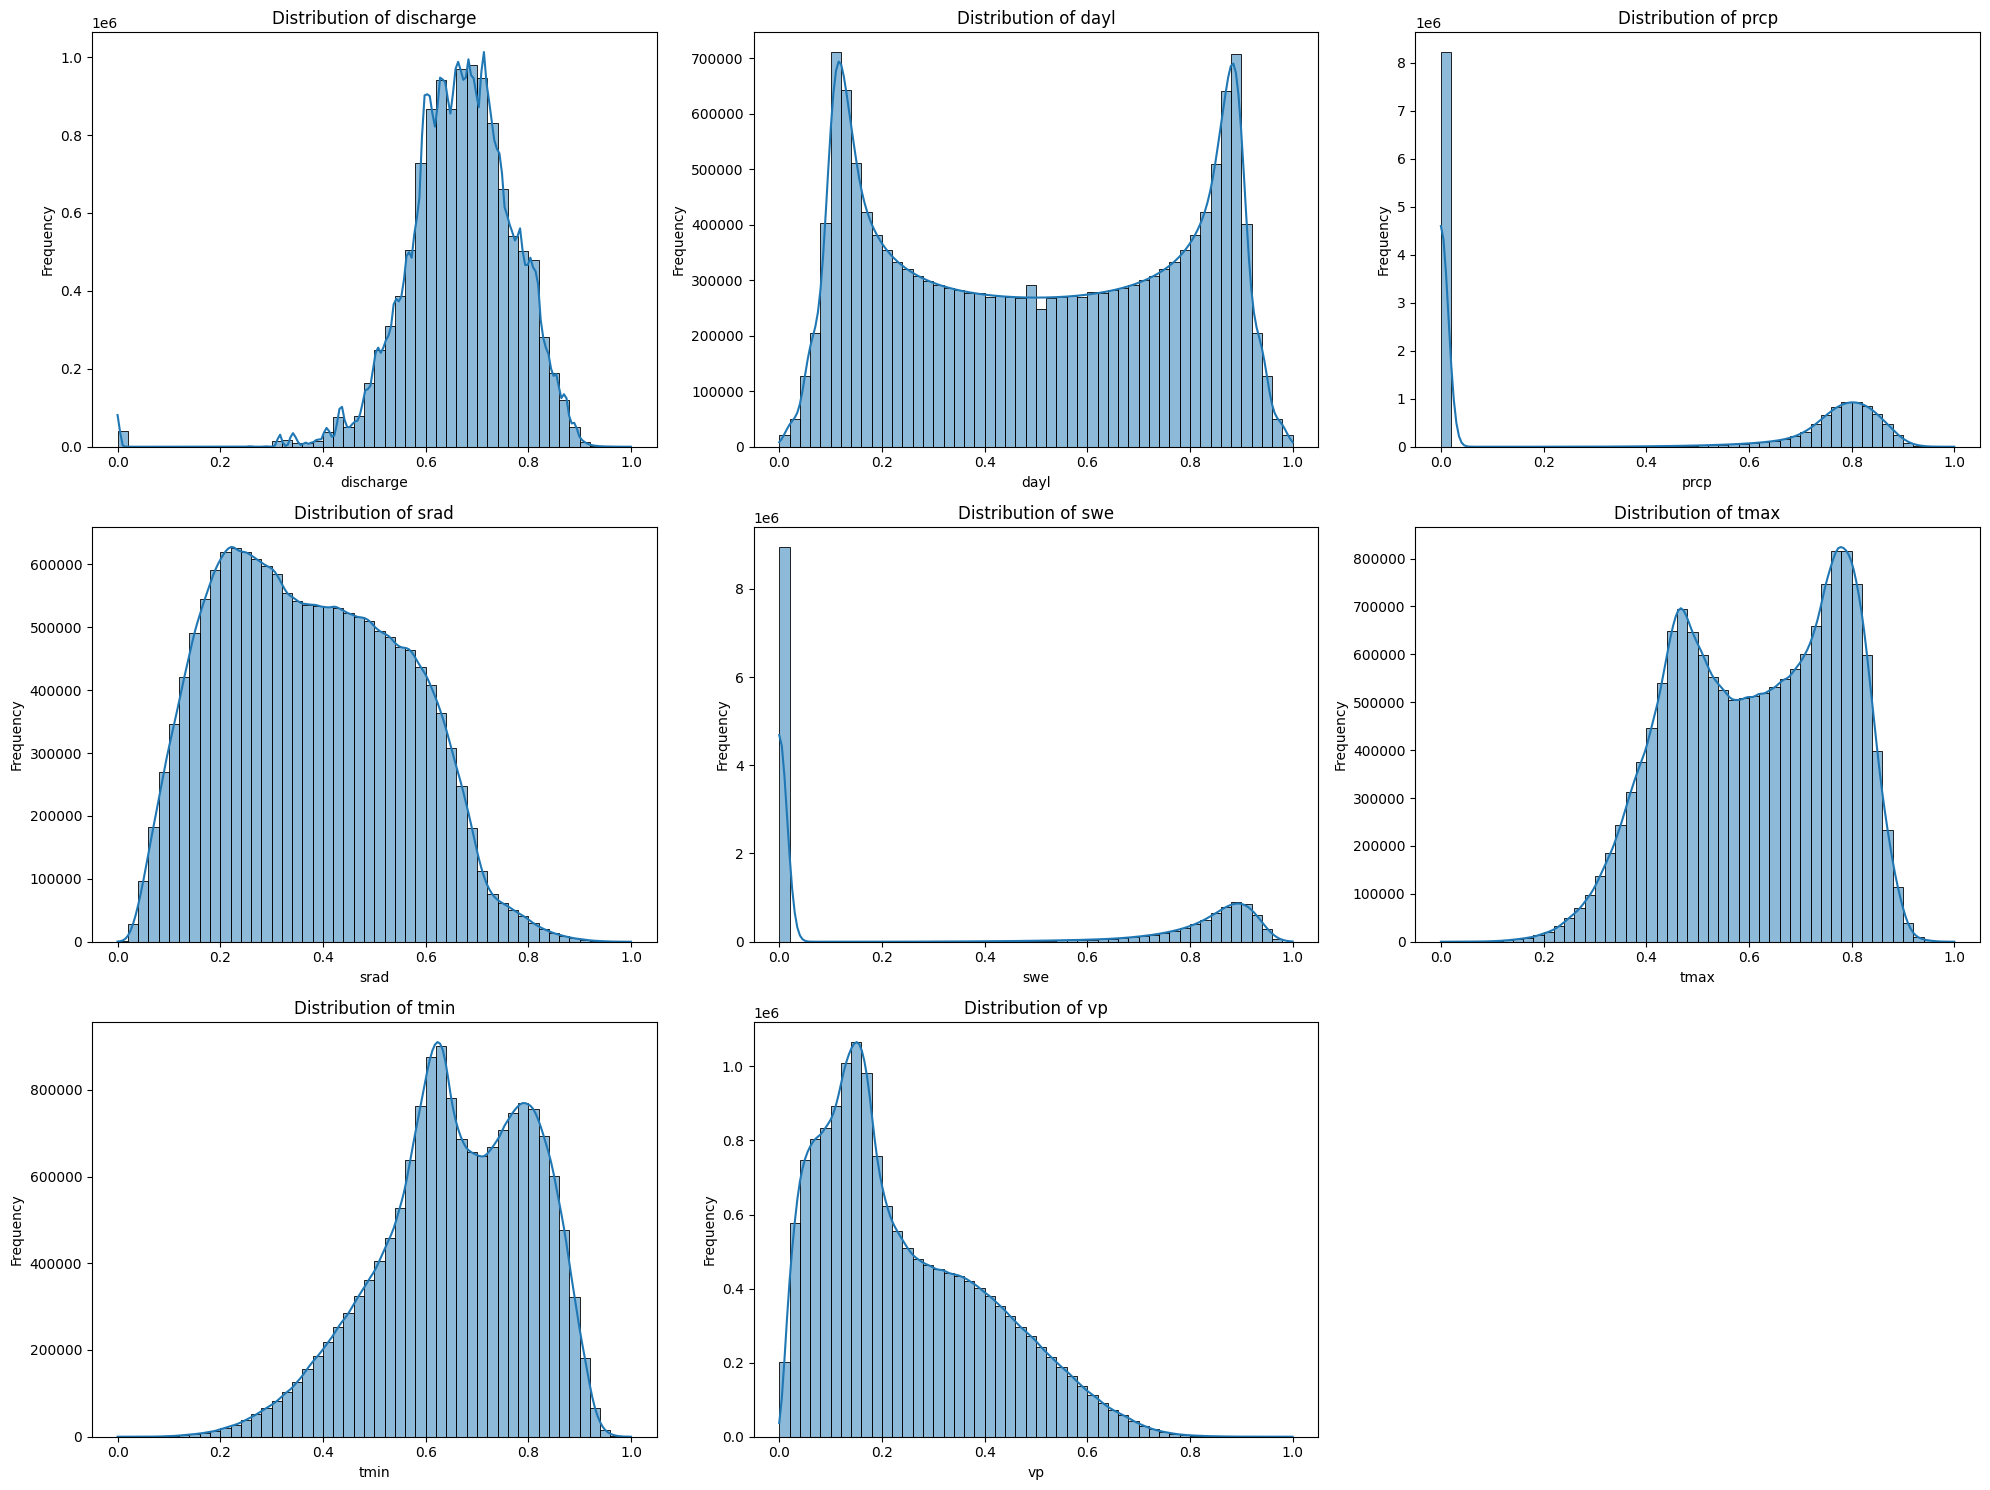

In [3]:
# Plot the distribution of each variable
variables = ['discharge', 'dayl', 'prcp', 'srad', 'swe', 'tmax', 'tmin', 'vp']

plt.figure(figsize=(20, 15))
for i, variable in tqdm(enumerate(variables, 1)):
    plt.subplot(3, 3, i)
    sns.histplot(combined_df[variable].dropna(), bins=50, kde=True)
    plt.xlabel(variable)
    plt.ylabel('Frequency')
    plt.title(f'Distribution of {variable}')

plt.tight_layout()
plt.show()